# Vehicle Detection Using Support Vector Machines

In [2]:
# import all required packages
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

## Feature Extraction

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    
    return features


# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features


# Define a function to extract features from a list of images
# Have this function call get_hog_features(), bin_spatial() and color_hist()
def extract_features(imgs, spatial_size=(32, 32), hist_bins=32,
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        feature_image = np.copy(image)      

        if spatial_feat == True:
            # Get binned features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat == True:
            # Get color histogram features
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))
    
    return features #, spatial_features, hist_features, hog_features

## Import Data

Number of Not Car Samples =  8968
Number of Car Samples =  8792


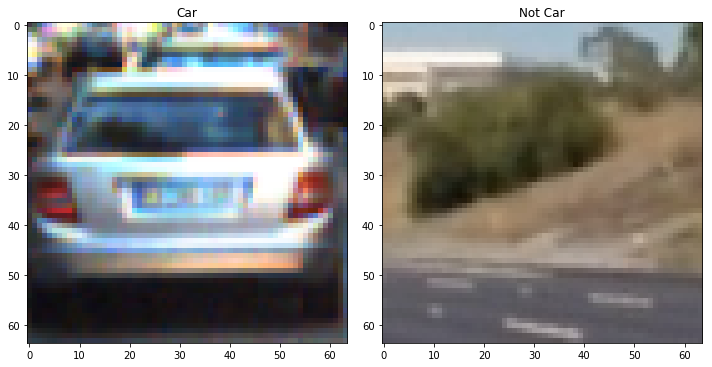

In [9]:
# Divide up images into cars and notcars
notcars = glob.glob('./data/non-vehicles/*.png')
cars = glob.glob('./data/vehicles/*.png')
print("Number of Not Car Samples = ",len(notcars))
print("Number of Car Samples = ",len(cars))

# Plotting a sample of car and not car
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(mpimg.imread(cars[300]))
plt.title('Car')
plt.subplot(122)
plt.imshow(mpimg.imread(notcars[300]))
plt.title('Not Car')
fig.tight_layout()
plt.show()

## Training a SVM Classifier

In [25]:
from sklearn.model_selection import train_test_split


# Set feature extraction parameters 
spatial_size=(32, 32)
hist_bins=32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_feat=True
hist_feat=True
hog_feat=True

# Apply extract_features() for car samples
car_features = extract_features(cars, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)


# Apply extract_features() for notcar samples
notcar_features = extract_features(notcars, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector (car: 1, notcar: 0)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using ...')
if spatial_feat==True:
    print('Spatial binned features with spatial_size = ',spatial_size)

if hist_feat==True:
    print('Color histogram features with ',hist_bins,'histogram bins')

if hog_feat==True:
    print('HOG features with ',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Number of Not Car Samples =  8968
Number of Car Samples =  8792
Using ...
Spatial binned features with spatial_size =  (32, 32)
Color histogram features with  32 histogram bins
HOG features with  9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
Test Accuracy of SVC =  0.9848


## Save the Classifier Model and Parameters 

In [26]:
# Store classifier data (serialize)
import pickle

classifier_data = {}
classifier_data["svc"] = svc
classifier_data["scaler"] = X_scaler 
classifier_data["orient"] = orient
classifier_data["pix_per_cell"] = pix_per_cell
classifier_data["cell_per_block"] = cell_per_block
classifier_data["spatial_size"] = spatial_size
classifier_data["hist_bins"] = hist_bins

with open('svc_data.pickle', 'wb') as handle:
    pickle.dump(classifier_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Load the Classifier Model and Parameters 

In [4]:
# Load data (deserialize)
import pickle

dist_pickle = pickle.load( open("./svc_data.pickle", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

## Detecting Cars on The Road

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

# Define a single function that can extract features and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bbox = []
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)
    ctrans_tosearch=img_tosearch
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size = spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
           
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img[:,:,::-1], bbox 

Trying the above function for three different window scales, we will have: 

C:\Users\msamadani\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


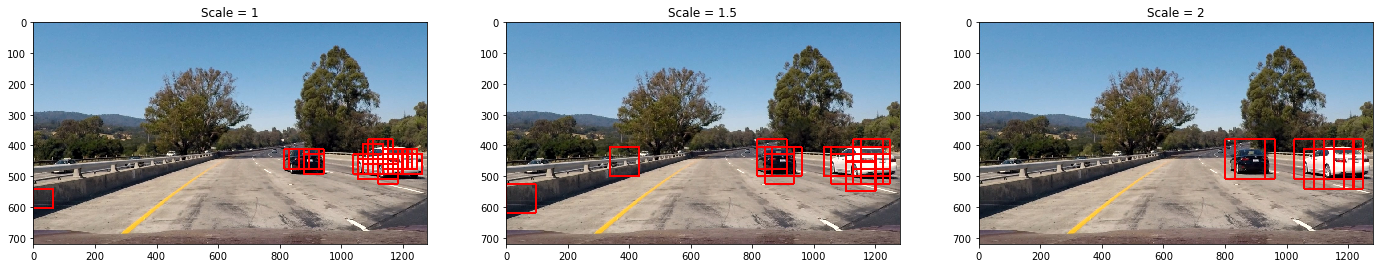

In [8]:
image = cv2.imread('./test_images/test1.jpg')

ystart = 380
ystop = 656
scales = [1,1.5,2]
 
box_list=[]
i=0
plt.figure(figsize=(24,15))
for scale in scales:
    i=i+1
    out_img, bbox = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list = box_list + bbox
    plt.subplot(1,3,i)
    plt.imshow(out_img)
    plt.title('Scale = '+str(scale))
plt.show()

## Multiple Detections & False Positives

The pictures above show all the bounding boxes for where the classifier reported positive detections using three sliding window scales. You can see that overlapping detections exist for each of the two vehicles, and in the first two pictures, I find a false positive detection on the guardrail to the left. In order to combine overlapping detections and remove false positives, I'll build a heat-map.

To make a heat-map, we're adding "heat" (+=1) for all pixels within windows where a positive detection is reported by the classifier.

In [9]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, box_list):
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

The individual heat-maps for the above images look like this:

C:\Users\msamadani\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


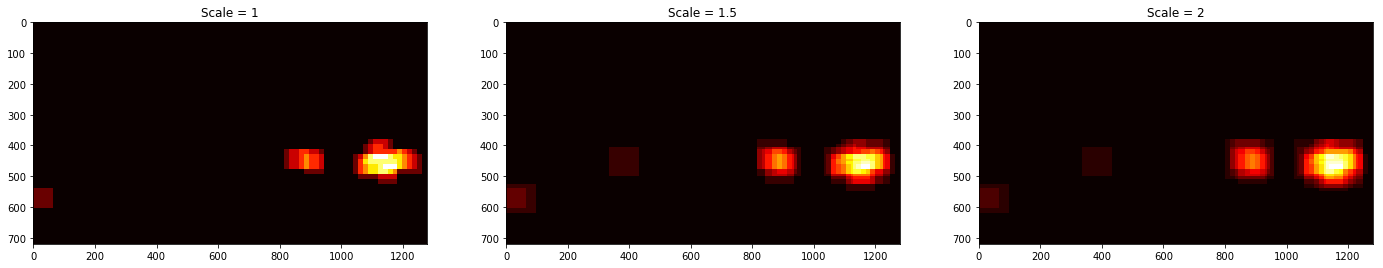

In [10]:
image = cv2.imread('./test_images/test1.jpg')

ystart = 380
ystop = 656
scales = [1,1.5,2]
 
box_list=[]
heat = np.zeros_like(image[:,:,0]).astype(np.float)
i=0

plt.figure(figsize=(24,15))
for scale in scales:
    i=i+1
    out_img, bbox = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list = box_list + bbox
    
    # Add heat to each box in box list
    heat = add_heat(heat,bbox)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    plt.subplot(1,3,i)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Scale = '+str(scale))
plt.show()

If the classifier is working well, then the "hot" parts of the map are where the cars are, and by imposing a threshold, we can reject areas affected by false positives. So let's write a function to threshold the map as well. In practice, I add all boxes detected with each scale to a python list called "box_list", create the heatmap from this list and apply the threshold to this heatmap. I can then draw boxes around the hot thresholded areas to determine the position of the cars. The result is shown below.

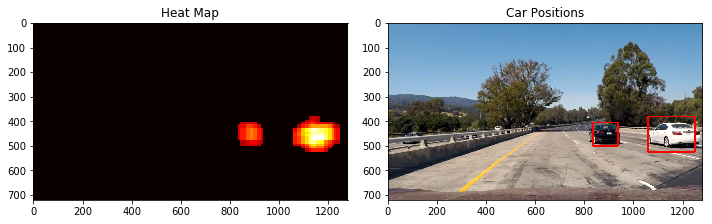

In [11]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,4)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(122)
plt.imshow(draw_img[:,:,::-1])
plt.title('Car Positions')
fig.tight_layout()
plt.show()


I will now write a function that takes an image, runs the classifier on image patches using a sliding window with three scales, creates a list of detected boxes, produces and thresholds the heatmap and detects the position of the cars on the road. The resultant heatmap and the final detection has been shown for several test images below. 

In [12]:
def detect_cars(img):
    
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    import numpy as np
    import pickle
    import cv2
    from scipy.ndimage.measurements import label
    
    ystart = 380
    ystop = 656
    scales = [1,1.5,2]
 
    spatial_size=(32, 32)
    hist_bins=32
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    #hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    box_list=[]

    for scale in scales:
        out_img, bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list = box_list + bbox
        
     
     # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels) 
    
    return heatmap, draw_img[:,:,::-1]

C:\Users\msamadani\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


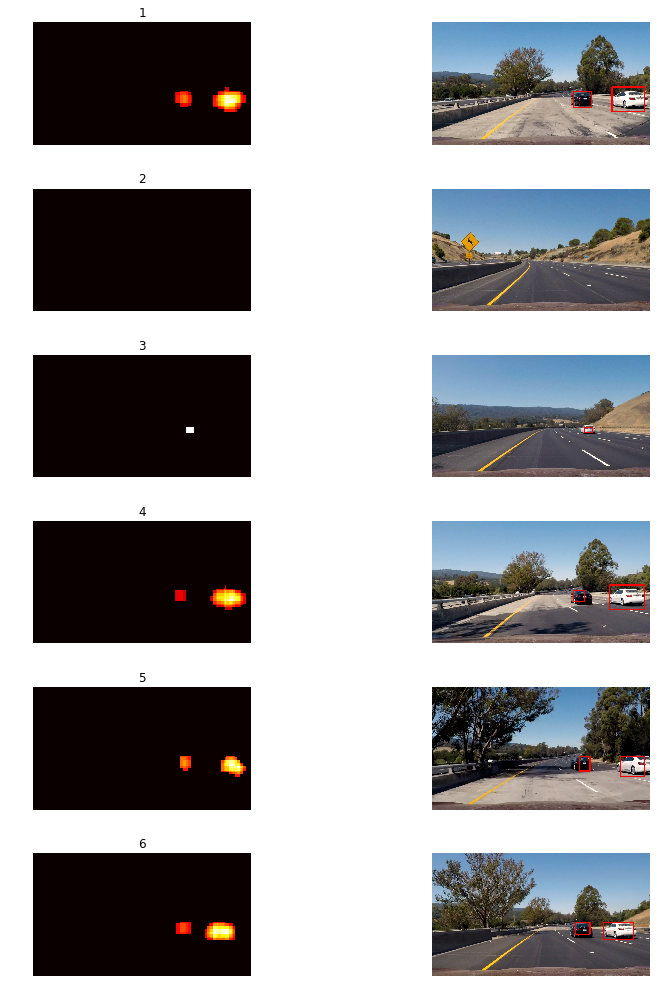

In [13]:
test_images = glob.glob('./test_images/*.jpg')

plt.figure(figsize=(15, 14))

for i in range(len(test_images)):
    image = cv2.imread(test_images[i])
    heatmap, processed_image = detect_cars(image)

    plt.subplot(6,2,2*i+1)
    plt.imshow(heatmap,cmap='hot')
    plt.axis('off')
    plt.title(i+1)
    plt.subplot(6,2,2*i+2)
    plt.imshow(processed_image)
    plt.axis('off')
    plt.tight_layout()    
plt.show()


## Create a Video

Finally I write a function to take video frames and perform the car detection pipeline and create an output video.

In [15]:
def process_image(img):
    
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    import numpy as np
    import pickle
    import cv2
    from scipy.ndimage.measurements import label
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    
    ystart = 380
    ystop = 656
    scales = [1,1.5,2]
 
    spatial_size=(32, 32)
    hist_bins=32
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    #hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    box_list=[]

    for scale in scales:
        out_img, bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list = box_list + bbox
        
     
     # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels) 
    
    return draw_img[:,:,::-1]

In [16]:
def create_video(video_name):
# Import everything needed to edit/save/watch video clips
    from moviepy.editor import VideoFileClip
    from IPython.display import HTML

    output_video = video_name+'_output.mp4'
    clip = VideoFileClip(video_name+'.mp4')

    out_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!

    %time out_clip.write_videofile(output_video, audio=False)

In [17]:
create_video('test_video')

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:59<00:01,  1.56s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 1min


In [18]:
create_video('project_video')

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [34:17<00:02,  2.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 34min 19s
